# Etap 2 KM 2 - inżynieria cech

In [2]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [3]:
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('../Data/our_data.csv')

In [5]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

cols = X.columns
cols

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

<AxesSubplot:xlabel='Class', ylabel='count'>

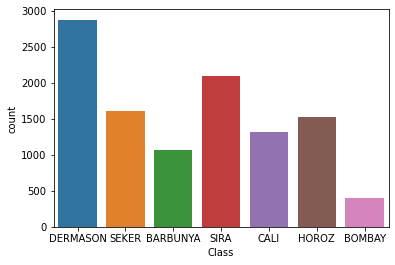

In [6]:
sns.countplot(x='Class', data = data)

Podczas procesu EDA zauważyliśmy:
- brak brakujących wartości  
- kolumna Compactness, Area, EquivDiameter zdecydowanie do usunięcia (bardzo duże korelacje)
- brak dużej ilości outlierów (tam wyżej niby były ale to taki rozkład był więc jednak nie)
- spory imbalans między liczbą konkretnych fasolek w zbiorze treningowym 

## 1. Normalizacja
Standaryzacja przy uzyciu MinMaxScaler  

In [7]:
# scaling = MinMaxScaler()
scaling = sklearn.preprocessing.StandardScaler()

#scaling = sklearn.preprocessing.PowerTransformer(method='yeo-johnson') - tutaj regresja logostyczna dziala lepiej
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)
X_val = scaling.transform(X_val)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)
X_val = pd.DataFrame(X_val, columns=cols)

## 2. Encoding
Zamiana zmiennej kategorycznej - nazw klas fasolek, przy użyciu ONE HOT ENCODING

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.to_frame())
y_encoded = pd.DataFrame(enc.transform(y_train.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_val_encoded = pd.DataFrame(enc.transform(y_val.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_test_encoded = pd.DataFrame(enc.transform(y_test.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))

#standard encoding 0,1,2,...
labelencoder = sklearn.preprocessing.LabelEncoder()
y_encoded2 = pd.DataFrame(labelencoder.fit_transform(y_train))
y_val_encoded2 = pd.DataFrame(labelencoder.fit_transform(y_val))
y_test_encoded2 = pd.DataFrame( labelencoder.fit_transform(y_test))
y_encoded


,Class_BARBUNYA,Class_BOMBAY,Class_CALI,Class_DERMASON,Class_HOROZ,Class_SEKER,Class_SIRA
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
7616,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7617,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7618,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7619,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 3. Feature Selection
### 3.1 Usunięcie kolumn na podstawie dużej korelacji w EDA

In [9]:
# delete columns with high correlations: Compactness,EquivDiameter, Area
X_train_filtered = X_train.drop(['Compactness','EquivDiameter', 'Area'], axis=1)
X_val_filtered = X_val.drop(['Compactness','EquivDiameter','Area'], axis=1)
X_test_filtered = X_test.drop(['Compactness','EquivDiameter','Area'], axis=1)
cols = X_train.columns
cols

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

### 3.2 Feature importance

Ranking cech: 
Cecha ShapeFactor3 (0.09953788691253616)
Cecha ShapeFactor1 (0.09759659076275314)
Cecha MinorAxisLength (0.09722616044801789)
Cecha MajorAxisLength (0.08887630248681729)
Cecha Compactness (0.08604824134559563)
Cecha Perimeter (0.0801720050433358)
Cecha ConvexArea (0.07551788576219516)
Cecha EquivDiameter (0.06503949687859417)
Cecha AspectRation (0.06265224102765304)
Cecha Eccentricity (0.06246398248807655)
Cecha Area (0.05518308610877318)
Cecha roundness (0.047969922950419484)
Cecha ShapeFactor2 (0.031418231682395)
Cecha ShapeFactor4 (0.029979886665613756)
Cecha Solidity (0.013935124140217133)
Cecha Extent (0.0063829552970067795)


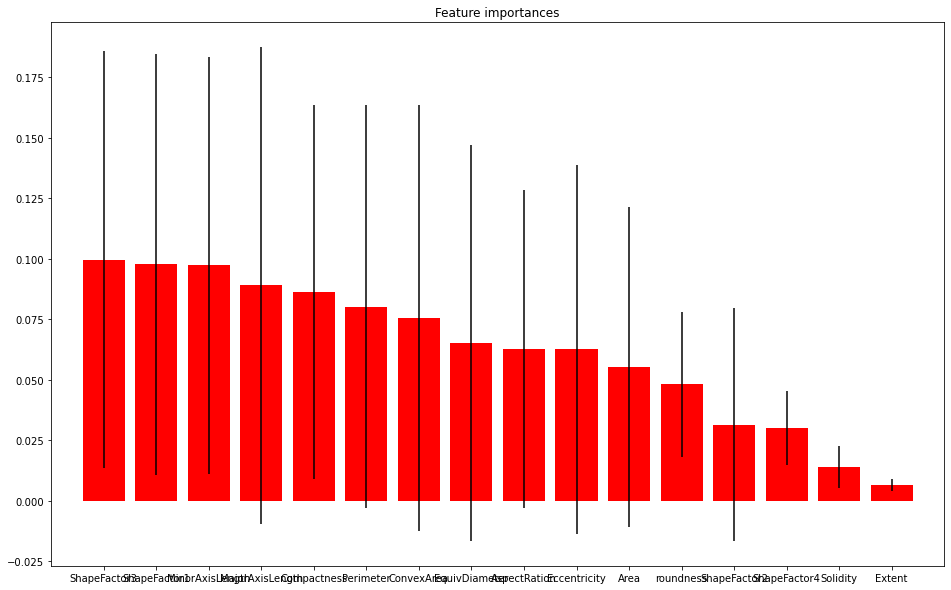

In [10]:
FI_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
FI_clf.fit(X_train, y_encoded)

feature_importances = FI_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in FI_clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]



print("Ranking cech: ")
for i in range(X_train.shape[1]):
    print(f"Cecha {cols[indices[i]]} ({feature_importances[indices[i]]})")

plt.figure(figsize=(16,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],yerr=std[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), [cols[i] for i in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [11]:
#delete Extent and Solidity
X_train_filtered = X_train_filtered.drop(['Extent','Solidity'], axis=1)
X_val_filtered = X_val_filtered.drop(['Extent','Solidity'], axis=1)
X_test_filtered = X_test_filtered.drop(['Extent','Solidity'], axis=1)

In [12]:
cols = X_train_filtered.columns
cols

Index(['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation',
       'Eccentricity', 'ConvexArea', 'roundness', 'ShapeFactor1',
       'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

# 4. ONE VS REST:
## - one vs. rest dla fasolki Bombay
Do modelu rozdzielającego Bombay od reszty transformujemy kolumnę zamieniając wartość na 1, gdy jest to bombay 0, gdy nie jest

### 4.1 **BOMBAY**

In [13]:
#bez usuwania kolumn
y_train_b = y_train.map(lambda x: 1 if x == 'BOMBAY' else 0)
y_val_b = y_val.map(lambda x: 1 if x == 'BOMBAY' else 0)
y_test_b = y_test.map(lambda x: 1 if x == 'BOMBAY' else 0)

In [14]:
clf_b = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_b.fit(X_train, y_train_b)
y_val_pred = clf_b.predict(X_val)

report = classification_report(y_val_b, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_b = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_b.fit(X_train_filtered, y_train_b)
y_val_pred = clf_b.predict(X_val_filtered)

report2 = classification_report(y_val_b, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      2201
           1    1.00000   1.00000   1.00000        85

    accuracy                        1.00000      2286
   macro avg    1.00000   1.00000   1.00000      2286
weighted avg    1.00000   1.00000   1.00000      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.99955   1.00000   0.99977      2201
           1    1.00000   0.98824   0.99408        85

    accuracy                        0.99956      2286
   macro avg    0.99977   0.99412   0.99693      2286
weighted avg    0.99956   0.99956   0.99956      2286



BOMBAY  - było tak pięknie przed usunięciem kolumn  
n_estimators = 1, max_depth = 100:  
Accuracy: 1.0  
F1 Score: 1.0  
Precision: 1.0  
Recall: 1.0  

n_estimators = 100, max_depth = 3:

Accuracy: 0.9995625546806649  
F1 Score: 0.9940828402366864  
Precision: 1.0  
Recall: 0.9882352941176471  

jest to zdumiewająco dobry wynik, ale patrząc na to jak odseparowany jest Bombay, to chyba jest w porządku

### 4.2 **SEKER**

In [15]:
y_train_s = y_train.map(lambda x: 1 if x == 'SEKER' else 0)
y_val_s = y_val.map(lambda x: 1 if x == 'SEKER' else 0)
y_test_s = y_test.map(lambda x: 1 if x == 'SEKER' else 0)

clf_s = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42)
clf_s.fit(X_train, y_train_s)
y_val_pred = clf_s.predict(X_val)

report = classification_report(y_val_s, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_s = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_s.fit(X_train_filtered, y_train_s)
y_val_pred = clf_s.predict(X_val_filtered)

report2 = classification_report(y_val_s, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    0.99181   0.99486   0.99333      1947
           1    0.96997   0.95280   0.96131       339

    accuracy                        0.98863      2286
   macro avg    0.98089   0.97383   0.97732      2286
weighted avg    0.98857   0.98863   0.98858      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.98563   0.98613   0.98588      1947
           1    0.92012   0.91740   0.91876       339

    accuracy                        0.97594      2286
   macro avg    0.95287   0.95177   0.95232      2286
weighted avg    0.97591   0.97594   0.97593      2286



SEKER  
n = 30, max = 10 -> 0.6s   (tu chyba z usunięciem kolumn)  
Accuracy: 0.9881889763779528  
F1 Score: 0.9597615499254843  
Precision: 0.9698795180722891  
Recall: 0.9498525073746312  

n = 1, max = 100  
Accuracy: 0.9768153980752406  
F1 Score: 0.9212481426448736  
Precision: 0.9281437125748503  
Recall: 0.9144542772861357  

### 4.3 **DERMASON**

In [16]:
y_train_d = y_train.map(lambda x: 1 if x == 'DERMASON' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'DERMASON' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'DERMASON' else 0)

clf_d = RandomForestClassifier(n_estimators=100, max_depth=2000, random_state=42)
clf_d.fit(X_train, y_train_d)
y_val_pred = clf_d.predict(X_val)

report = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_d = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_d.fit(X_train_filtered, y_train_d)
y_val_pred = clf_d.predict(X_val_filtered)

report2 = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    0.97197   0.96908   0.97053      1682
           1    0.91461   0.92219   0.91838       604

    accuracy                        0.95669      2286
   macro avg    0.94329   0.94563   0.94446      2286
weighted avg    0.95682   0.95669   0.95675      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.95873   0.95303   0.95587      1682
           1    0.87134   0.88576   0.87849       604

    accuracy                        0.93526      2286
   macro avg    0.91503   0.91940   0.91718      2286
weighted avg    0.93564   0.93526   0.93543      2286



### 4.4 **HOROZ**

In [17]:
y_train_d = y_train.map(lambda x: 1 if x == 'HOROZ' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'HOROZ' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'HOROZ' else 0)

clf_d = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42)
clf_d.fit(X_train, y_train_d)
y_val_pred = clf_d.predict(X_val)

report = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_d = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_d.fit(X_train_filtered, y_train_d)
y_val_pred = clf_d.predict(X_val_filtered)

report2 = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report2)


Report:
               precision    recall  f1-score   support

           0    0.99288   0.99187   0.99237      1967
           1    0.95016   0.95611   0.95312       319

    accuracy                        0.98688      2286
   macro avg    0.97152   0.97399   0.97275      2286
weighted avg    0.98691   0.98688   0.98689      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.98928   0.98526   0.98726      1967
           1    0.91131   0.93417   0.92260       319

    accuracy                        0.97813      2286
   macro avg    0.95030   0.95971   0.95493      2286
weighted avg    0.97840   0.97813   0.97824      2286



### 4.5 **SIRA**

In [18]:
y_train_d = y_train.map(lambda x: 1 if x == 'SIRA' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'SIRA' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'SIRA' else 0)

clf_d = RandomForestClassifier(n_estimators=30, max_depth=100, random_state=42)
clf_d.fit(X_train, y_train_d)
y_val_pred = clf_d.predict(X_val)

report = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_d = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_d.fit(X_train_filtered, y_train_d)
y_val_pred = clf_d.predict(X_val_filtered)

report2 = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    0.96316   0.97778   0.97041      1845
           1    0.90073   0.84354   0.87119       441

    accuracy                        0.95188      2286
   macro avg    0.93194   0.91066   0.92080      2286
weighted avg    0.95112   0.95188   0.95127      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.95600   0.95393   0.95496      1845
           1    0.80899   0.81633   0.81264       441

    accuracy                        0.92738      2286
   macro avg    0.88250   0.88513   0.88380      2286
weighted avg    0.92764   0.92738   0.92751      2286



### 4.6 **BARBUNYA**

In [19]:
y_train_d = y_train.map(lambda x: 1 if x == 'BARBUNYA' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'BARBUNYA' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'BARBUNYA' else 0)

clf_d = RandomForestClassifier(n_estimators=36, max_depth=10, random_state=42)
clf_d.fit(X_train, y_train_d)
y_val_pred = clf_d.predict(X_val)

report = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_d = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_d.fit(X_train_filtered, y_train_d)
y_val_pred = clf_d.predict(X_val_filtered)

report2 = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    0.99036   0.99564   0.99299      2064
           1    0.95735   0.90991   0.93303       222

    accuracy                        0.98731      2286
   macro avg    0.97385   0.95277   0.96301      2286
weighted avg    0.98716   0.98731   0.98717      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.98596   0.98692   0.98644      2064
           1    0.87727   0.86937   0.87330       222

    accuracy                        0.97550      2286
   macro avg    0.93162   0.92814   0.92987      2286
weighted avg    0.97541   0.97550   0.97545      2286



### 4.7**CALI**

In [20]:
y_train_d = y_train.map(lambda x: 1 if x == 'CALI' else 0)
y_val_d = y_val.map(lambda x: 1 if x == 'CALI' else 0)
y_test_d = y_test.map(lambda x: 1 if x == 'CALI' else 0)

clf_d = RandomForestClassifier(n_estimators=26, max_depth=27, random_state=42)
clf_d.fit(X_train, y_train_d)
y_val_pred = clf_d.predict(X_val)

report = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report)

print("Z USUNIĘCIEM KOLUMN")
clf_d = RandomForestClassifier(n_estimators=1, max_depth=100, random_state=42)
clf_d.fit(X_train_filtered, y_train_d)
y_val_pred = clf_d.predict(X_val_filtered)

report2 = classification_report(y_val_d, y_val_pred, digits=5)
print("Report:\n", report2)

Report:
               precision    recall  f1-score   support

           0    0.98426   0.99552   0.98986      2010
           1    0.96443   0.88406   0.92250       276

    accuracy                        0.98206      2286
   macro avg    0.97434   0.93979   0.95618      2286
weighted avg    0.98187   0.98206   0.98173      2286

Z USUNIĘCIEM KOLUMN
Report:
               precision    recall  f1-score   support

           0    0.98507   0.98458   0.98482      2010
           1    0.88809   0.89130   0.88969       276

    accuracy                        0.97332      2286
   macro avg    0.93658   0.93794   0.93726      2286
weighted avg    0.97336   0.97332   0.97334      2286



Po usunięciu kolumn accuracy i f1 score przy podejściu one vs. rest generalnie spada, więc jeśli uzyjemy tego, to trzeba wziąć pod uwagę

# 5. Testowanie modeli dla wszystkich fasolek

In [21]:
class_names = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

### 5.1 Regresja logistyczna

In [22]:
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train, y_encoded2)
y_pred = reg.predict(X_val)
print("BEFORE FEATURE SELECTION:\n")
print(f"Accuracy: {reg.score(X_val, y_val_encoded2)}")
report = classification_report(y_val_encoded2, y_pred)
print("Report:\n", report)

y_pred = labelencoder.inverse_transform(y_pred)
cm1 = confusion_matrix(y_val, y_pred, labels=class_names)
#print(f"confusion matrix:")
#print(cm)

# Plot confusion matrix
fig = px.imshow(cm1, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()


print("AFTER FEATURE SELECTION:\n")
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train_filtered, y_encoded2)
y_pred = reg.predict(X_val_filtered)
print(f"Accuracy: {reg.score(X_val_filtered, y_val_encoded2)}")
report = classification_report(y_val_encoded2, y_pred)
print("Report:\n", report)

#print(f"confusion matrix:")
#print(cm)
y_pred = labelencoder.inverse_transform(y_pred)
cm2 = confusion_matrix(y_val, y_pred, labels=class_names)
cm3 = cm2 - cm1

# Plot confusion matrix
fig = px.imshow(cm3, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()




BEFORE FEATURE SELECTION:

Accuracy: 0.9234470691163604
Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       222
           1       1.00      1.00      1.00        85
           2       0.96      0.92      0.94       276
           3       0.92      0.93      0.92       604
           4       0.93      0.96      0.94       319
           5       0.96      0.96      0.96       339
           6       0.85      0.87      0.86       441

    accuracy                           0.92      2286
   macro avg       0.94      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



AFTER FEATURE SELECTION:

Accuracy: 0.9216972878390202
Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       222
           1       1.00      1.00      1.00        85
           2       0.95      0.91      0.93       276
           3       0.92      0.92      0.92       604
           4       0.92      0.96      0.94       319
           5       0.96      0.96      0.96       339
           6       0.85      0.86      0.86       441

    accuracy                           0.92      2286
   macro avg       0.94      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



### 5.2 SVM - support vector machine

In [23]:
#tu encodowane dane dają błąd 
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train, y_encoded2)
#uwaga na zmiane parametrow bo moze sie robic kilka dni
y_pred = svm.predict(X_val)
report = classification_report(y_val_encoded2, y_pred)
print("Report:\n", report)

y_pred = labelencoder.inverse_transform(y_pred)
cm1 = confusion_matrix(y_val, y_pred, labels=class_names)
#print(f"confusion matrix:")
#print(cm)

# Plot confusion matrix
fig = px.imshow(cm1, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()


print("AFTER FEATURE SELECTION:\n")
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train_filtered, y_encoded2)
print("SVM accuracy: {:.2f}".format(svm.score(X_val_filtered, y_val_encoded2)))
print("SVM f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded2, svm.predict(X_val_filtered), average='weighted')))
y_pred = labelencoder.inverse_transform(svm.predict(X_val_filtered))

report = classification_report(y_val, y_pred)
print("Report:\n", report)

#print(f"confusion matrix:")
#print(cm)
cm2 = confusion_matrix(y_val, y_pred, labels=class_names)
cm3 = cm2 - cm1

# Plot confusion matrix
fig = px.imshow(cm3, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()

Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       222
           1       1.00      1.00      1.00        85
           2       0.95      0.92      0.93       276
           3       0.92      0.93      0.92       604
           4       0.93      0.95      0.94       319
           5       0.96      0.96      0.96       339
           6       0.86      0.86      0.86       441

    accuracy                           0.92      2286
   macro avg       0.94      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



AFTER FEATURE SELECTION:

SVM accuracy: 0.92
SVM f1 score: 0.92
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.94      0.92      0.93       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.95      0.90      0.93       276
    DERMASON       0.92      0.93      0.92       604
       HOROZ       0.92      0.95      0.94       319
       SEKER       0.96      0.96      0.96       339
        SIRA       0.86      0.86      0.86       441

    accuracy                           0.92      2286
   macro avg       0.94      0.93      0.93      2286
weighted avg       0.92      0.92      0.92      2286



SVM accuracy: 0.92
SVM f1 score: 0.92 - dotychczas jest to najlepiej działający model

### 5.3 DecisionTreeClassifier
### ZWIZUALIZOWAC DRZEWO

In [28]:
#tree
from sklearn import tree 

print("ENCODED")
tree1 = DecisionTreeClassifier(max_depth=7, random_state=42)
tree1.fit(X_train, y_encoded)

y_hat = tree1.predict(X_val)


report = classification_report(y_val_encoded, y_hat)
print("Report:\n", report)
y_hat = enc.inverse_transform(y_hat)
#cm1 = confusion_matrix(y_val, y_hat)

#visualize tree
import graphviz
feature_names = X_train.columns
dot_data = tree.export_graphviz(tree1, 
                  feature_names=feature_names,  
                  class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render("tree")

#print(f"confusion matrix:")
#print(cm)

# fig = px.imshow(cm1, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
# fig.update_xaxes(side="top")
# fig.show()



print("AFTER FEATURE SELECTION:\n")
tree1 = DecisionTreeClassifier(max_depth=10000, random_state=42)
tree1.fit(X_train_filtered, y_encoded)
y_hat = tree1.predict(X_val_filtered)
print("Tree accuracy: {:.2f}".format(tree1.score(X_val_filtered, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))
report = classification_report(y_val_encoded, y_hat)
print("Report:\n", report)

y_hat = enc.inverse_transform(y_hat)
cm2 = confusion_matrix(y_val, y_hat)
#print(f"confusion matrix:")
#print(cm)

cm3 = cm2 - cm1
# Plot confusion matrix
# fig = px.imshow(cm3, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
# fig.update_xaxes(side="top")
# fig.show()



ENCODED
Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90       222
           1       1.00      0.99      0.99        85
           2       0.92      0.89      0.91       276
           3       0.89      0.95      0.92       604
           4       0.92      0.94      0.93       319
           5       0.95      0.92      0.94       339
           6       0.87      0.83      0.85       441

   micro avg       0.91      0.91      0.91      2286
   macro avg       0.93      0.91      0.92      2286
weighted avg       0.91      0.91      0.91      2286
 samples avg       0.91      0.91      0.91      2286

AFTER FEATURE SELECTION:

Tree accuracy: 0.89
Tree f1 score: 0.89
Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       222
           1       1.00      1.00      1.00        85
           2       0.89      0.89      0.89       276
           3       0.89      0.89      0

Tree accuracy: 0.89  
Tree f1 score: 0.89

In [25]:
#dodanie CRITERION GINI
tree = DecisionTreeClassifier(max_depth=10000, random_state=42, criterion='gini')
tree.fit(X_train, y_encoded)
y_hat = tree.predict(X_val)
print("Tree accuracy: {:.2f}".format(tree.score(X_val, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))

y_hat = enc.inverse_transform(y_hat)
cm1 = confusion_matrix(y_val, y_hat)
#print(f"confusion matrix:")
#print(cm)
fig = px.imshow(cm1, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()


Tree accuracy: 0.89
Tree f1 score: 0.89


### 5.4 Random Forest - najwyższe accuracy i f1 = 0.93

In [26]:
#Lepsze wyniki dla danyh niezakodowanyh
print("zwykly encoding")
forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini')
forest.fit(X_train, y_encoded2)
y_hat = forest.predict(X_val)
print("Forest accuracy: {:.2f}".format(forest.score(X_val, y_val_encoded2)))
print("Forest f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded2, y_hat, average='weighted')))

y_hat = labelencoder.inverse_transform(y_hat)

cm = confusion_matrix(y_val, y_hat, labels=class_names)
report = classification_report(y_val, y_hat)
print("Report:\n", report)


fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()

print("OneHotEncoding")
forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini')
forest.fit(X_train, y_encoded)
y_hat = forest.predict(X_val)
#when inverse.transform returns NONE, we will change it to BOMBAY

#cm = confusion_matrix(y_val, y_hat, labels=class_names)
report = classification_report(y_val_encoded, y_hat)
print("Report:\n", report)


# fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
# fig.update_xaxes(side="top")
# fig.show()

print("PO USUNIĘCIU KOLUMN")
forest = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini')
forest.fit(X_train_filtered, y_train)
y_hat = forest.predict(X_val_filtered)
print("Forest accuracy: {:.2f}".format(forest.score(X_val_filtered, y_val)))
print("Forest f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val, y_hat, average='weighted')))

cm2 = confusion_matrix(y_val, y_hat)
#print(f"confusion matrix:")
#print(cm)
report = classification_report(y_val, y_hat)
print("Report:\n", report)


fig = px.imshow(cm2-cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()



zwykly encoding
Forest accuracy: 0.93
Forest f1 score: 0.93
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.95      0.91      0.93       276
    DERMASON       0.91      0.93      0.92       604
       HOROZ       0.94      0.95      0.94       319
       SEKER       0.96      0.96      0.96       339
        SIRA       0.87      0.86      0.87       441

    accuracy                           0.93      2286
   macro avg       0.94      0.93      0.94      2286
weighted avg       0.93      0.93      0.93      2286



OneHotEncoding
Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       222
           1       1.00      0.99      0.99        85
           2       0.96      0.90      0.93       276
           3       0.91      0.92      0.92       604
           4       0.95      0.95      0.95       319
           5       0.96      0.95      0.96       339
           6       0.88      0.84      0.86       441

   micro avg       0.93      0.91      0.92      2286
   macro avg       0.94      0.92      0.93      2286
weighted avg       0.93      0.91      0.92      2286
 samples avg       0.91      0.91      0.91      2286

PO USUNIĘCIU KOLUMN
Forest accuracy: 0.92
Forest f1 score: 0.92
Report:
               precision    recall  f1-score   support

    BARBUNYA       0.90      0.91      0.91       222
      BOMBAY       1.00      1.00      1.00        85
        CALI       0.95      0.88      0.92       276
    DERMASON       0.91      0.92  

### 5.5 AdaBoost 

In [27]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=7, random_state=42)
ada.fit(X_train, y_encoded2)
y_hat = ada.predict(X_val)
print("AdaBoost accuracy: {:.2f}".format(ada.score(X_val, y_val_encoded2)))
print("AdaBoost f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded2, y_hat, average='weighted')))
cm = confusion_matrix(y_val_encoded2, y_hat)

report = classification_report(y_val_encoded2, y_hat)
print("Report:\n", report)

fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=class_names, y=class_names,text_auto='.2f')
fig.update_xaxes(side="top")
fig.show()

AdaBoost accuracy: 0.74
AdaBoost f1 score: 0.71
Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       222
           1       1.00      1.00      1.00        85
           2       0.50      0.99      0.67       276
           3       0.80      0.86      0.83       604
           4       0.92      0.75      0.83       319
           5       0.97      0.63      0.76       339
           6       0.69      0.83      0.75       441

    accuracy                           0.74      2286
   macro avg       0.70      0.72      0.69      2286
weighted avg       0.71      0.74      0.71      2286



Dane bez OneHotEncodingu dają lepszy wynik. A przynajmniej przetestowane przez nas modele które działają dla obu encodingów.

Usuwanie kolumn, pewnie ze względu na ich małą początkową ilość wpływa negatywnie na efektywność modeli

fajnie by było przetestowac jeszcze połączenie one vs. rest którychś fasolek z najbardziej dotychczas efektownym modelem np. Random Forest (modelowanie dwu albo nawet trzy etapowe) ale z uwagi na ograniczenia czasowe zrobimy to później albo nie